In [1]:
%matplotlib inline
import math
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr

from sklearn import tree
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn import neighbors
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

C:\Users\danie\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df_train = pd.read_csv("abalone_data.csv") 

In [3]:
df_train.head()
# dobbiamo creare un modello che predica il numero di rings, dopo aver discretizzato l'attributo ring in due intervalli

,sex,lenght,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
sex               4177 non-null object
lenght            4177 non-null float64
diameter          4177 non-null float64
height            4177 non-null float64
whole_weight      4177 non-null float64
shucked_weight    4177 non-null float64
viscera_weight    4177 non-null float64
shell_weight      4177 non-null float64
rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [5]:
# dobbiamo scartare gli infanti
df_train = df_train[df_train['sex'] != 'I']
df_train.head()

,sex,lenght,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2835 entries, 0 to 4176
Data columns (total 9 columns):
sex               2835 non-null object
lenght            2835 non-null float64
diameter          2835 non-null float64
height            2835 non-null float64
whole_weight      2835 non-null float64
shucked_weight    2835 non-null float64
viscera_weight    2835 non-null float64
shell_weight      2835 non-null float64
rings             2835 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 221.5+ KB


In [7]:
# Get the unique values of sex
sexes = sorted(df_train['sex'].unique())
    
# Generate a mapping of sex from a string to a number representation    
genders_mapping = dict(zip(sexes, range(0, len(sexes) + 1)))

# Transform Sex from a string to a number representation
df_train['sex_val'] = df_train['sex'].map(genders_mapping).astype(int)

# Drop the coloumn sex
df_train = df_train.drop(['sex'], axis=1)


df_train.head()

# F = 0, M = 1

,lenght,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_val
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,1
6,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20,0


In [8]:
df_train['rings'].describe()

count    2835.000000
mean       10.900882
std         3.069252
min         3.000000
25%         9.000000
50%        10.000000
75%        12.000000
max        29.000000
Name: rings, dtype: float64

(array([   3.,    6.,   15.,   43.,  124.,  294.,  516.,  542.,  425.,
         246.,  179.,  112.,   93.,   60.,   51.,   37.,   30.,   24.,
          13.,    6.,    9.,    2.,    1.,    1.,    2.,    1.]),
 array([  3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
         14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
         25.,  26.,  27.,  28.,  29.]),
 <a list of 26 Patch objects>)

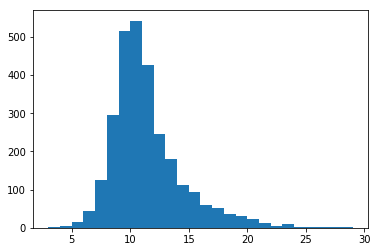

In [9]:
plt.hist(df_train['rings'], bins=len(df_train['rings'].unique()))

In [10]:
# discretizzazione dell'attributo rings
III_quart = df_train['rings'].quantile(0.75)        # utilizziamo il terzo quartile

# Generate a mapping of rings, 1 if rings > III quart    
def rings_mapping(x):
    if x > III_quart:
        return 1
    return 0

# Transform rings from an integer to a 0-1 representation
df_train['class'] = df_train['rings'].map(rings_mapping).astype(int)

# Drop the coloumn rings
df_train = df_train.drop(['rings'], axis=1)

In [11]:
df_train.head()

,lenght,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_val,class
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,1,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,1,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,1,0
6,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,0,1


In [12]:
# Convert the DataFrame to a numpy array:
df_nb = df_train.drop(['sex_val'], axis=1).copy()      # non serve la colonna sex nel nb sui valori numerici
train_data = df_nb.values
train_data

array([[ 0.455 ,  0.365 ,  0.095 , ...,  0.101 ,  0.15  ,  1.    ],
       [ 0.35  ,  0.265 ,  0.09  , ...,  0.0485,  0.07  ,  0.    ],
       [ 0.53  ,  0.42  ,  0.135 , ...,  0.1415,  0.21  ,  0.    ],
       ..., 
       [ 0.6   ,  0.475 ,  0.205 , ...,  0.2875,  0.308 ,  0.    ],
       [ 0.625 ,  0.485 ,  0.15  , ...,  0.261 ,  0.296 ,  0.    ],
       [ 0.71  ,  0.555 ,  0.195 , ...,  0.3765,  0.495 ,  0.    ]])

In [13]:
# Training data features, skip the last column 'class'
train_features = train_data[:, :len(train_data[0])-1]

# 'class' column values
train_target = train_data[:, len(train_data[0])-1]

In [14]:
train_features[0]

array([ 0.455 ,  0.365 ,  0.095 ,  0.514 ,  0.2245,  0.101 ,  0.15  ])

In [15]:
train_target[0]

1.0

In [16]:
from sklearn.cross_validation import train_test_split

train_x, test_x, train_y, test_y = train_test_split(train_features, 
                                                    train_target, 
                                                    test_size=0.10, 
                                                    random_state=0)

In [17]:
# FINE LAVORAZIONE SUL DATASET

In [18]:
#
# Naive Bayes
#
# RICORDA
# train_data = df_train.values
# train_features = train_data[:, :len(train_data[0])-1]
# train_target = train_data[:, len(train_data[0])-1]

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# Gaussian NB, for normally distributed numerical values  --> more generally applicable
gnb = GaussianNB()
gnb.fit(train_features, train_target)

for i in range(10):
    p = gnb.predict(train_features[i].reshape(1, -1))
    print (i, ":", train_features[i], "predicted: ", p[0], " real: ", train_target[i])
error = sum(abs(np.array(gnb.predict(train_features)) - np.array(train_target)))
errorRate = error/len(df_train)
print ("error:", error, "\terror rate:", errorRate)

0 : [ 0.455   0.365   0.095   0.514   0.2245  0.101   0.15  ] predicted:  0.0  real:  1.0
1 : [ 0.35    0.265   0.09    0.2255  0.0995  0.0485  0.07  ] predicted:  0.0  real:  0.0
2 : [ 0.53    0.42    0.135   0.677   0.2565  0.1415  0.21  ] predicted:  0.0  real:  0.0
3 : [ 0.44    0.365   0.125   0.516   0.2155  0.114   0.155 ] predicted:  0.0  real:  0.0
4 : [ 0.53    0.415   0.15    0.7775  0.237   0.1415  0.33  ] predicted:  0.0  real:  1.0
5 : [ 0.545   0.425   0.125   0.768   0.294   0.1495  0.26  ] predicted:  0.0  real:  1.0
6 : [ 0.475   0.37    0.125   0.5095  0.2165  0.1125  0.165 ] predicted:  0.0  real:  0.0
7 : [ 0.55    0.44    0.15    0.8945  0.3145  0.151   0.32  ] predicted:  0.0  real:  1.0
8 : [ 0.525   0.38    0.14    0.6065  0.194   0.1475  0.21  ] predicted:  0.0  real:  1.0
9 : [ 0.43    0.35    0.11    0.406   0.1675  0.081   0.135 ] predicted:  0.0  real:  0.0
error: 1040.0 	error rate: 0.36684303351


In [19]:
y_score = gnb.predict_proba(test_x)     
# alla roc curve devo passargli le previsioni con le probabilità

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
roc_auc = auc(fpr, tpr)

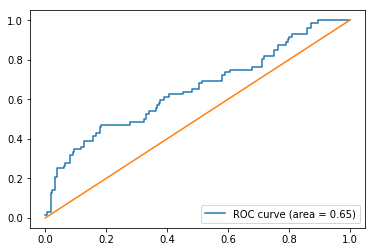

In [20]:
plt.plot(fpr,tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(np.linspace(0, 1), np.linspace(0,1))

plt.legend(loc="lower right")
plt.show()

In [21]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

scores = cross_validation.cross_val_score(gnb, train_features, train_target, cv=10)
print ('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.62 (+/- 0.31)


In [22]:
# PER USARE NAIVE BAYES IN MODO FURBO BISOGNA DISCRETIZZARE LE COLONNE DI TIPO FLOAT
df_train.head()

,lenght,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_val,class
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,1,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,1,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,1,0
6,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,0,1


In [23]:
df_train.describe()

,lenght,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_val,class
count,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000
mean,0.569552,0.446407,0.154437,1.016849,0.439051,0.222526,0.291208,0.538977,0.219048
std,0.095821,0.078850,0.037421,0.453217,0.212193,0.101880,0.128835,0.498566,0.413674
min,0.155000,0.110000,0.015000,0.015500,0.006500,0.003000,0.005000,0.000000,0.000000
25%,0.515000,0.400000,0.135000,0.701250,0.287000,0.152000,0.202500,0.000000,0.000000
50%,0.585000,0.460000,0.155000,1.003000,0.431500,0.217000,0.285000,1.000000,0.000000
75%,0.635000,0.500000,0.175000,1.289500,0.568750,0.287500,0.365000,1.000000,0.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,1.000000,1.000000


In [24]:
# discretizzazione delle colonne con attributi reali
df_train_nb = df_train.copy()

for attr in df_train_nb.columns[:len(df_train_nb.columns)-2]:
    df_train_nb[attr] = pd.cut(df_train_nb[attr], bins=10, right=False)

df_train_nb.head()

,lenght,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_val,class
0,"[0.419, 0.485)","[0.326, 0.38)","[0.015, 0.126)","[0.297, 0.578)","[0.155, 0.303)","[0.0787, 0.154)","[0.105, 0.205)",1,1
1,"[0.287, 0.353)","[0.218, 0.272)","[0.015, 0.126)","[0.0155, 0.297)","[0.0065, 0.155)","[0.003, 0.0787)","[0.005, 0.105)",1,0
2,"[0.485, 0.551)","[0.38, 0.434)","[0.126, 0.238)","[0.578, 0.858)","[0.155, 0.303)","[0.0787, 0.154)","[0.205, 0.305)",0,0
3,"[0.419, 0.485)","[0.326, 0.38)","[0.015, 0.126)","[0.297, 0.578)","[0.155, 0.303)","[0.0787, 0.154)","[0.105, 0.205)",1,0
6,"[0.485, 0.551)","[0.38, 0.434)","[0.126, 0.238)","[0.578, 0.858)","[0.155, 0.303)","[0.0787, 0.154)","[0.305, 0.405)",0,1


In [25]:
# vorrei fosse come prima, ma non posso trasformarlo in np.array! Quindi faccio cosi
for attr in df_train.columns[:len(df_train.columns)-2]:
    df_train[attr] = pd.cut(df_train[attr], bins=10, right=False, labels=range(10))

df_train.head()

,lenght,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_val,class
0,4,4,0,1,1,1,1,1,1
1,2,2,0,0,0,0,0,1,0
2,5,5,1,2,1,1,2,0,0
3,4,4,0,1,1,1,1,1,0
6,5,5,1,2,1,1,3,0,1


In [26]:
# Convert the DataFrame to a numpy array:
train_data_nb = df_train.values

# Training data features, skip the last column 'class'
train_features_nb = train_data_nb[:, :len(train_data_nb[0])-1].astype(float)

# 'Class' column values
train_target_nb = train_data_nb[:, len(train_data_nb[0])-1].astype(float)

# Multinomial NB, for discrete labels (yet still numerical)
mnb = MultinomialNB()
mnb.fit(train_features_nb, train_target_nb)

for i in range(10):
    p_nb = mnb.predict(train_features_nb[i].reshape(1, -1))
    print (i, ":", train_features_nb[i], "predicted: ", p_nb[0], " real: ", train_target_nb[i])

error = sum(abs(np.array(mnb.predict(train_features_nb)) - np.array(train_target_nb)))
errorRate = error/len(df_train)
print ("error:", error, "\terror rate:", errorRate)

0 : [ 4.  4.  0.  1.  1.  1.  1.  1.] predicted:  0.0  real:  1.0
1 : [ 2.  2.  0.  0.  0.  0.  0.  1.] predicted:  0.0  real:  0.0
2 : [ 5.  5.  1.  2.  1.  1.  2.  0.] predicted:  0.0  real:  0.0
3 : [ 4.  4.  0.  1.  1.  1.  1.  1.] predicted:  0.0  real:  0.0
4 : [ 5.  5.  1.  2.  1.  1.  3.  0.] predicted:  0.0  real:  1.0
5 : [ 5.  5.  0.  2.  1.  1.  2.  0.] predicted:  0.0  real:  1.0
6 : [ 4.  4.  0.  1.  1.  1.  1.  1.] predicted:  0.0  real:  0.0
7 : [ 5.  6.  1.  3.  2.  1.  3.  0.] predicted:  0.0  real:  1.0
8 : [ 5.  5.  1.  2.  1.  1.  2.  0.] predicted:  0.0  real:  1.0
9 : [ 4.  4.  0.  1.  1.  1.  1.  1.] predicted:  0.0  real:  0.0
error: 618.0 	error rate: 0.217989417989


In [27]:
train_x_nb, test_x_nb, train_y_nb, test_y_nb = train_test_split(train_features_nb, 
                                                    train_target_nb, 
                                                    test_size=0.10, 
                                                    random_state=0)

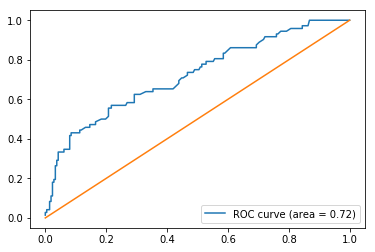

In [28]:
y_score_nb = mnb.predict_proba(test_x_nb)     

fpr_nb, tpr_nb, _ =  roc_curve(test_y_nb, y_score_nb[:,1])
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.plot(fpr_nb,tpr_nb, label='ROC curve (area = %0.2f)' % roc_auc_nb)
plt.plot(np.linspace(0, 1), np.linspace(0,1))

plt.legend(loc="lower right")

plt.show()

In [29]:
scores = cross_validation.cross_val_score(mnb, train_features, train_target, cv=10)
print ('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.78 (+/- 0.00)


In [30]:
# Risistemiamo il dataset
df_train = pd.read_csv("abalone_data.csv") 

df_train = df_train[df_train['sex'] != 'I']

# Get the unique values of sex
sexes = sorted(df_train['sex'].unique())
    
# Generate a mapping of sex from a string to a number representation    
genders_mapping = dict(zip(sexes, range(0, len(sexes) + 1)))

# Transform Sex from a string to a number representation
df_train['sex_val'] = df_train['sex'].map(genders_mapping).astype(int)

# Drop the coloumn sex
df_train = df_train.drop(['sex'], axis=1)

# F = 0, M = 1

# discretizzazione dell'attributo rings
III_quart = df_train['rings'].quantile(0.75)        # utilizziamo il III quartile

# Generate a mapping of rings, 1 if rings > median    
def rings_mapping(x):
    if x > III_quart:
        return 1
    return 0

# Transform rings from an integer to a 0-1 representation
df_train['class'] = df_train['rings'].map(rings_mapping).astype(int)

# Drop the coloumn rings
df_train = df_train.drop(['rings'], axis=1)

In [31]:
# Convert the DataFrame to a numpy array:
train_data = df_train.values
train_data

array([[ 0.455,  0.365,  0.095, ...,  0.15 ,  1.   ,  1.   ],
       [ 0.35 ,  0.265,  0.09 , ...,  0.07 ,  1.   ,  0.   ],
       [ 0.53 ,  0.42 ,  0.135, ...,  0.21 ,  0.   ,  0.   ],
       ..., 
       [ 0.6  ,  0.475,  0.205, ...,  0.308,  1.   ,  0.   ],
       [ 0.625,  0.485,  0.15 , ...,  0.296,  0.   ,  0.   ],
       [ 0.71 ,  0.555,  0.195, ...,  0.495,  1.   ,  0.   ]])

In [32]:
# Training data features, skip the last column 'class'
train_features = train_data[:, :len(train_data[0])-1]

# 'class' column values
train_target = train_data[:, len(train_data[0])-1]

In [33]:
# normalizzo

train_features = (train_features - train_features.mean(axis=0))/ train_features.std(axis=0)

In [34]:
train_x, test_x, train_y, test_y = train_test_split(train_features, 
                                                    train_target, 
                                                    test_size=0.10, 
                                                    random_state=0)

In [ ]:
#
# Support Vector Machines
#
# RICORDA
# train_data = df_train.values
# train_features = train_data[:, :len(train_data[0])-1]
# train_target = train_data[:, len(train_data[0])-1]

from sklearn import svm

clf = svm.SVC(probability = True)
clf.fit(train_features, train_target)
error = sum(abs(np.array(clf.predict(train_features)) - np.array(train_target)))
errorRate = error/len(df_train)
print ("error:", error, "\terror rate:", errorRate)

In [ ]:
y_score = clf.predict_proba(test_x)     


fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
roc_auc = auc(fpr, tpr)

In [ ]:
plt.plot(fpr,tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(np.linspace(0, 1), np.linspace(0,1))

plt.legend(loc="lower right")
plt.show()

In [ ]:
scores = cross_validation.cross_val_score(clf, train_features, train_target, cv=10)
print ('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

In [ ]:
# Cerchiamo i parametri migliori con il metodo del prof

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# I parametri da cercare sono il peso agli errori e il grado con cui dividere il dataset

In [ ]:
clf = svm.SVC()

param_dist = {'C': np.linspace(0.001, 20, 100)
             }
            

n_iter_search = len(param_dist["C"])

search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, 
                            n_jobs=10, scoring=make_scorer(accuracy_score))

search.fit(train_features, train_target)

report(search.cv_results_, 3) #search.best_estimator_.estimators_[0]


In [ ]:
clf = svm.SVC(C=2.425121212121212, probability=True)
clf.fit(train_features, train_target)
error = sum(abs(np.array(clf.predict(train_features)) - np.array(train_target)))
errorRate = error/len(df_train)
print ("error:", error, "\terror rate:", errorRate)

In [ ]:
y_score = clf.predict_proba(test_x)     

fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(np.linspace(0, 1), np.linspace(0,1))

plt.legend(loc="lower right")
plt.show()

In [ ]:
scores = cross_validation.cross_val_score(clf, train_features, train_target, cv=10)
print ('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

In [ ]:
clf = svm.SVC(C=2.6271313131313128, probability=True)
clf.fit(train_features, train_target)
error = sum(abs(np.array(clf.predict(train_features)) - np.array(train_target)))
errorRate = error/len(df_train)
print ("error:", error, "\terror rate:", errorRate)

In [ ]:
y_score = clf.predict_proba(test_x)     

fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(np.linspace(0, 1), np.linspace(0,1))

plt.legend(loc="lower right")
plt.show()

In [ ]:
scores = cross_validation.cross_val_score(clf, train_features, train_target, cv=10)
print ('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

In [ ]:
clf = svm.SVC(C=2.829141414141414, probability=True)
clf.fit(train_features, train_target)
error = sum(abs(np.array(clf.predict(train_features)) - np.array(train_target)))
errorRate = error/len(df_train)
print ("error:", error, "\terror rate:", errorRate)

In [ ]:
y_score = clf.predict_proba(test_x)     

fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(np.linspace(0, 1), np.linspace(0,1))

plt.legend(loc="lower right")
plt.show()

In [ ]:
scores = cross_validation.cross_val_score(clf, train_features, train_target, cv=10)
print ('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

In [ ]:
# proviamo boosting e bagging

In [ ]:
# Bagging

from sklearn.ensemble import BaggingClassifier

clf = svm.SVC(C=2.425121212121212, probability=True)

# max_sample = 100% + Bootstrap ==> ~62% of original dataset used as sample
bag = BaggingClassifier(clf, n_estimators=20, max_samples=1.0, bootstrap=True)
bag = bag.fit(train_x, train_y)

y_score = bag.predict_proba(test_x)
fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
print ("Bagging:", auc(fpr, tpr))

clf = clf.fit(train_x, train_y)
y_score = clf.predict_proba(test_x)
fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
print ("Single SVM:", auc(fpr, tpr))


In [ ]:
%%time
# Bagging / 2

from sklearn.ensemble import BaggingClassifier

results = []
for nnn in range(50):
    
    clf = svm.SVC(C=2.425121212121212, probability=True)

    # max_sample = 100% + Bootstrap ==> ~62% of original dataset used as sample
    bag = BaggingClassifier(clf, n_estimators=20, max_samples=1.0, bootstrap=True)
    bag = bag.fit(train_x, train_y)

    y_score = bag.predict_proba(test_x)
    fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
    # print auc(fpr, tpr)
    results.append(auc(fpr, tpr))
plt.hist(results)

In [ ]:
# Boosting with AdaBoost
from sklearn.ensemble import AdaBoostClassifier

clf = svm.SVC(C=2.425121212121212, probability=True)

ada = AdaBoostClassifier(base_estimator=clf, n_estimators=100)
ada = ada.fit(train_x, train_y)

y_score = ada.predict_proba(test_x)
fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
print (auc(fpr, tpr))
